# OkCupid: Dataset Analysis

This is a notebook I am using to test out the feasibility of using the [OkCupid Dataset](https://github.com/rudeboybert/JSE_OkCupid) for our first workshop.

In [10]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

#constants
%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 5

# Dataset Information

Before starting with the analysis of this dataset, it will be important to study the codebook of variables in ```data/JSE_OkCupid/okcupid_codebook.txt```. Some important notes I found from viewing this codebook:

* Contains Profiles from 25 Mile Radius outside of San Francisco, with at least one profile picture.

* Data Scraped in 2012.

* Contains $n = 59946$ observations; This is a mid-sized dataset, with a lot of information, although nont big-data unweildy.

* Contains a mix of different demographic and lifestyle data, along with some textual data in the ```essay``` variables.

With that in mind, let's get started with the data.

In [3]:
okCupidFrame = pd.read_csv("data/JSE_OkCupid/profiles.csv")

# Assessing Data Quality

As is usual for starting data analyses, let's assess some aspects of data quality.

In [4]:
numObservations = okCupidFrame.shape[0]
numFeatures = okCupidFrame.shape[1]

As discussed in the codebook, we see that we have {{numObservations}} profiles in this dataset. We also have {{numFeatures}} variables in this dataset, and given that some of these variables are language data (see [the dataset's codebook](data/JSE_OkCupid/okcupid_codebook.txt)), this dataset can be very high-dimensional if we choose to transform it in that manner.

Let us study how many missing values we have in this dataset.

In [13]:
#make numMissing for a given column
def numMissing(col):
    #helper that checks the number of observations missing from a given col
    missingRows = col[col.isnull()]
    return missingRows.shape[0]
#then apply over our feature set
missingSummaryFrame = okCupidFrame.apply(numMissing,axis = 0)
display(missingSummaryFrame)

age                0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
essay0          5485
essay1          7571
essay2          9638
essay3         11476
essay4         10537
essay5         10847
essay6         13771
essay7         12450
essay8         19214
essay9         12602
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
orientation        0
pets           19921
religion       20226
sex                0
sign           11056
smokes          5512
speaks            50
status             0
dtype: int64

_Table 1: Counts of the number of observations missing per variable._

We see that we have variables with many missing variables, and this is especially consistent with the language data (i.e. the ```essay``` variables). This may suggest that we want to target a particular variable that generally has fewer misisng observations. Let us try out targeting the ```age``` variable.

# Summary Statistics and EDA

Let us start by studying the distribution of our target variable ```age``` and some of the potentially relevant variables for determining age of someone on OkCupid.

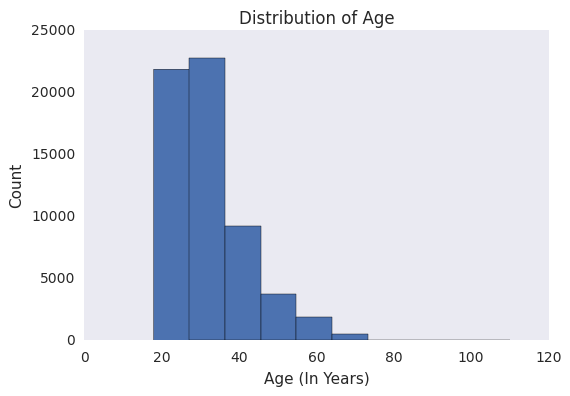

In [15]:
#plot age
plt.hist(okCupidFrame["age"])
#then make some labels
plt.xlabel("Age (In Years)")
plt.ylabel("Count")
plt.title("Distribution of Age")

_Figure 1: Distribution of Age._

We see that the distribution of age is fairly young, with most people being around $20$ to $35$ years old. We see that the distribution is relatively right-skewed, with fewer observations among middle-aged individuals. This may have an effect towards a relatively imbalanced regression.

Perhaps income might be useful in determining age, as generally older persons tend to have higher incomes from being farther in their careers. Let us study the distribution of income.

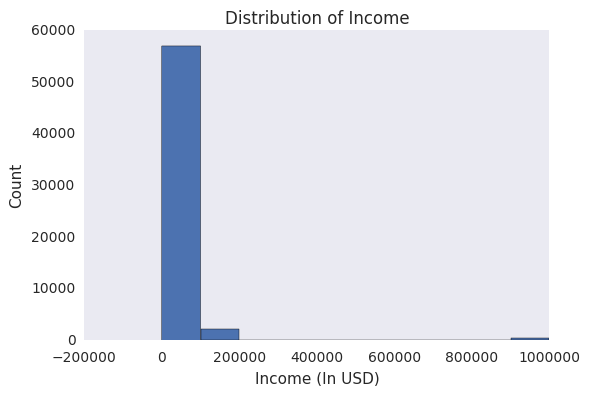

In [17]:
plt.hist(okCupidFrame["income"])
plt.xlabel("Income (In USD)")
plt.ylabel("Count")
plt.title("Distribution of Income")

_Figure 2: Distribution of Income (in USD)._

We see that the distribution of income is heavily right-skewed, as in typical of income distributions. That being said, it is apparent that this distribution may be affected by the "Prefer not to say" category ($-1$ in this variable). Let us see how many of those observations occur.

In [21]:
numNotReportIncome = okCupidFrame[okCupidFrame["income"] == -1].shape[0]
propNotReportIncome = float(numNotReportIncome) / okCupidFrame.shape[0]
#get percent
percentMul = 100
percentNotReportIncome = propNotReportIncome * percentMul

We see that {{numNotReportIncome}} of our observations did not report their income, which is about {{int(np.round(percentNotReportIncome))}}% of the observations in our dataset. This is not ideal, and this suggests that this variable will not be strong for informing our age observations.

Another possible option is to look at the summary of individuals (```essay0```) to inform us of their age. It is likely that the language content, language complexity, and summary length will be strong informers of an individual's maturity, which is (hopefully) correlated with their age.

Let us filter out the observations that do not have the summary (around {{missingSummaryFrame["essay0"]}} observations) and then study that language.

In [24]:
filteredOkCupidFrame = okCupidFrame[okCupidFrame["essay0"].notnull()]

We will start analyzing this data by first filtering out all the stopwords (i.e. punctuation) from our data and remove any words that are not featured in the standard english dictionary. We will use the [Natural Language Toolkit](http://www.nltk.org) to perform this task.

In [25]:
#language imports
import nltk
import collections as co
import StringIO
import re
#find full distribution of word frequencies
#write the all to a string wrtier
stringWriteTerm = StringIO.StringIO()
filteredOkCupidFrame["essay0"].apply(lambda x: stringWriteTerm.write(x))
#get the full string from the writer
summaryString = stringWriteTerm.getvalue()
stringWriteTerm.close()
#lower and split into series of words (tokens) on multiple split criteria
summaryString = summaryString.lower()
#split on ".", " ", ";", "-", or new line
summaryWordList = re.split("\.| |,|;|-|\n",summaryString)

In [26]:
#keep only legal words, and non stop-words (i.e. "." or "&")
#get counter of legal English
legalWordCounter = co.Counter(nltk.corpus.words.words())
stopWordsCounter = co.Counter(nltk.corpus.stopwords.words())
#filter narrativeWordList
filterSummaryWordList = [i for i in summaryWordList
                           if i in legalWordCounter and
                              i not in stopWordsCounter]
#counter for the legal words in our filtered list
filteredWordCounter = co.Counter(filterSummaryWordList)

We see that there are {{sum(filteredWordCounter.values())}} non-distinct words that occur in the entire corpus of summaries and {{len(filteredWordCounter.values())}} distinct words in this corpus. This is actually a rather diverse set of possible words that occur. Let us look at the distribution of the words by rank.

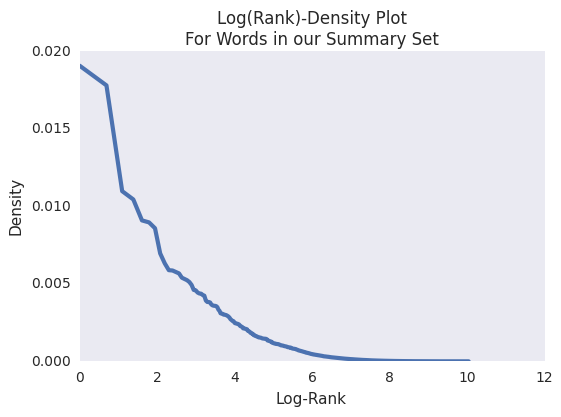

In [30]:
#make series of word frequency ordered by most common words
wordFrequencyFrame = pd.DataFrame(filteredWordCounter.most_common(),
                                  columns = ["Word","Frequency"])
wordFrequencyFrame["Density"] = (wordFrequencyFrame["Frequency"] /
                                np.sum(wordFrequencyFrame["Frequency"]))
#then plot rank-density plot
#for the sake of easier visuals, we will log the rank
desiredLineWidth = 3
plt.plot(np.log(wordFrequencyFrame.index+1),wordFrequencyFrame["Density"],
         lw = desiredLineWidth)
plt.xlabel("Log-Rank")
plt.ylabel("Density")
plt.title("Log(Rank)-Density Plot\nFor Words in our Summary Set")

_Figure 3: Our word distribution by $\log(Rank)$ of a word._

We see that this distribution dissipates after about the top $e^6 \approx 403$ most frequent words in our corpus, which suggests that this is a very sparse language. Since we have over $20000$ possible words in our corpus and only about $403$ of them are used that often, this suggests to me that if we were to do a formal model selection procedure, we would need to not consider many words that occur very rarely.

Let us see what our top ten most frequent words look like.

In [31]:
topLev = 10
topTenWordFrame = wordFrequencyFrame.iloc[0:topLev,:].loc[:,
                                                        ["Word","Frequency"]]
#then display
display(HTML(topTenWordFrame.to_html(index = False)))

Word,Frequency
love,46721
like,43604
life,26893
people,25578
new,22271
time,21956
good,21031
enjoy,17052
get,15484
looking,14405


_Table 2: Our Top Ten Most Frequent words along with their frequencies in our corpus._

We see that our summaries are generally focused around "love", and aspects of affection ("like","enjoy","good", etc).

# Prediction

Let us try to use these summaries to predict the age of an individual. We will do this by regressing age on a bag-of-words representation of our summaries. We will use [Scikit-Learn](http://scikit-learn.org/stable/) for building our bag-of-words per each observation.

In [33]:
#import our count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
#make a vocab dictionary
counterList = filteredWordCounter.most_common()
vocabDict = {}
for i in xrange(len(counterList)):
    rankWord = counterList[i][0]
    vocabDict[rankWord] = i
#initialize vectorizer
vectorizer = CountVectorizer(min_df=1,stop_words=stopWordsCounter,
                             vocabulary = vocabDict)
#then fit and transform our summaries
bagOfWordsMatrix = vectorizer.fit_transform(filteredOkCupidFrame["essay0"])

In [ ]:
#get language frame
langFrame = pd.DataFrame(bagOfWordsMatrix.toarray(),
                         columns = vectorizer.get_feature_names())
#import linear model
import sklearn.linear_model as lm
#build model
initialLinearMod = lm.LinearRegression()
initialLinearMod.fit(langFrame,filteredOkCupidFrame["age"])

Let us first study how well our model is performing on the dataset. We will use the error metric root mean-squared error (RMSE).

In [ ]:
#get predictions
predictionVec = initialLinearMod.predict(langFrame)